# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            _, indices = torch.max(prediction, 1)
            correct_samples += float(torch.sum(indices == y))
            total_samples += float(y.shape[0])
            loss_accum += float(loss_value.item())
            

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        if scheduler is not None:
            scheduler.step(ave_loss)
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct = 0 
    total = 0 
    with torch.no_grad():
        for i_step, (x, y) in enumerate(loader):
                prediction = torch.argmax(model(x) , 1)    
                for i in range(len(prediction)):
                    if prediction[i] == y[i]:
                        correct += 1
                total += len(prediction)
    return float(correct/total)
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.826641, Train accuracy: 0.410777, Val accuracy: 0.546038
Average loss: 1.452091, Train accuracy: 0.584718, Val accuracy: 0.601597
Average loss: 1.375956, Train accuracy: 0.621336, Val accuracy: 0.609242
Average loss: 1.346297, Train accuracy: 0.635873, Val accuracy: 0.625418
Average loss: 1.331549, Train accuracy: 0.642955, Val accuracy: 0.630332


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 10))
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.192485, Train accuracy: 0.205917, Val accuracy: 0.236980
Average loss: 2.034889, Train accuracy: 0.263113, Val accuracy: 0.283940
Average loss: 1.855723, Train accuracy: 0.337440, Val accuracy: 0.391919
Average loss: 1.721011, Train accuracy: 0.417380, Val accuracy: 0.417787
Average loss: 1.684834, Train accuracy: 0.433829, Val accuracy: 0.428094


Добавьте слой с Batch Normalization

In [8]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
            nn.BatchNorm1d(10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.810392, Train accuracy: 0.405317, Val accuracy: 0.613405
Average loss: 1.347668, Train accuracy: 0.644047, Val accuracy: 0.696130
Average loss: 1.251074, Train accuracy: 0.696755, Val accuracy: 0.702341
Average loss: 1.206294, Train accuracy: 0.717742, Val accuracy: 0.732783
Average loss: 1.176597, Train accuracy: 0.735488, Val accuracy: 0.755307


Добавьте уменьшение скорости обучения по ходу тренировки.

In [9]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
            nn.BatchNorm1d(10)
         )
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= True)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10, scheduler)

Average loss: 1.771598, Train accuracy: 0.437344, Val accuracy: 0.622824
Average loss: 1.343786, Train accuracy: 0.650531, Val accuracy: 0.707597
Average loss: 1.250760, Train accuracy: 0.696089, Val accuracy: 0.720497
Average loss: 1.203361, Train accuracy: 0.721155, Val accuracy: 0.735649
Average loss: 1.172382, Train accuracy: 0.738900, Val accuracy: 0.742953
Average loss: 1.149611, Train accuracy: 0.747927, Val accuracy: 0.729575
Average loss: 1.129060, Train accuracy: 0.758404, Val accuracy: 0.762337
Average loss: 1.112857, Train accuracy: 0.766287, Val accuracy: 0.774828
Average loss: 1.096034, Train accuracy: 0.773402, Val accuracy: 0.736127
Average loss: 1.082638, Train accuracy: 0.777446, Val accuracy: 0.767524


Average loss: 1.068151, Train accuracy: 0.784288, Val accuracy: 0.786021
Average loss: 1.056147, Train accuracy: 0.788093, Val accuracy: 0.797625
Average loss: 1.045359, Train accuracy: 0.790397, Val accuracy: 0.789844
Average loss: 1.030926, Train accuracy: 0.795140, Val accuracy: 0.796464
Average loss: 1.018824, Train accuracy: 0.802085, Val accuracy: 0.800218
Average loss: 1.011566, Train accuracy: 0.802222, Val accuracy: 0.808409
Average loss: 0.998265, Train accuracy: 0.806027, Val accuracy: 0.811207
Average loss: 0.990646, Train accuracy: 0.808910, Val accuracy: 0.795168


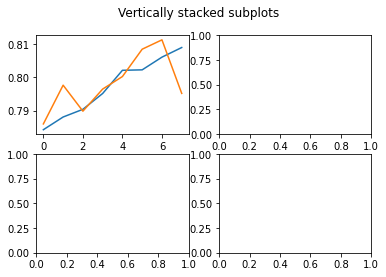

In [10]:
#
scheduler_1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= True)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 8, scheduler_1)
fig, axs = plt.subplots(2, 2)
fig.suptitle('Vertically stacked subplots')
axs[0][0].plot(train_history)
axs[0][0].plot(val_history)
#
"""
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler_2 = optim.lr_scheduler.MultiStepLR(optimizer , milestones=[3,8] , verbose= True)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 8, scheduler_2)
axs[0][1].plot(train_history)
axs[0][1].plot(val_history)
#
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler_3 = optim.lr_scheduler.StepLR(optimizer , step_size = 3 , verbose= True)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 8, scheduler_3)
axs[1][0].plot(train_history)
axs[1][0].plot(val_history)
#
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler_4 = optim.lr_scheduler.ExponentialLR(optimizer , gamma = 0.1 , verbose= True)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 8, scheduler_4)
axs[1][1].plot(train_history)
axs[1][1].plot(val_history)
"""
plt.show()

# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [11]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    with torch.no_grad():
        for i_step, (x, y) in enumerate(torch.utils.data.DataLoader(dataset, batch_size=len(indices),sampler=SubsetSampler(indices))):
                predictions = torch.argmax(model(x) , 1)    
                ground_truth = y
    
    return predictions.numpy(), ground_truth.numpy()

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

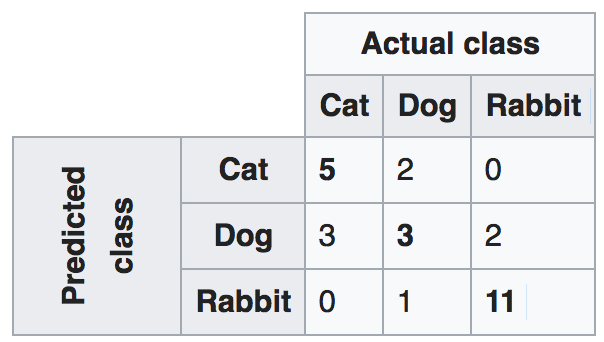

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

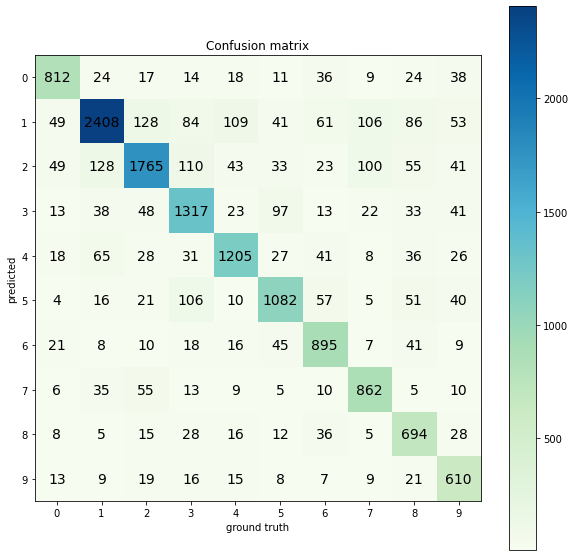

In [12]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    confusion_matrix = np.zeros((10,10), np.int)
    # TODO: Implement filling the prediction matrix
    for i in range(predictions.shape[0]):
        confusion_matrix[predictions[i]][ground_truth[i]] += 1
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

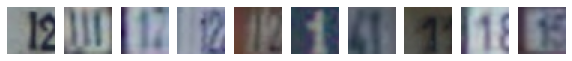

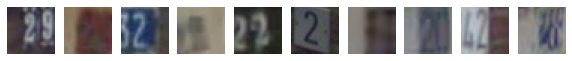

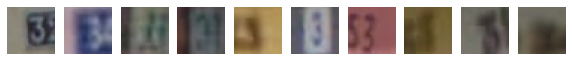

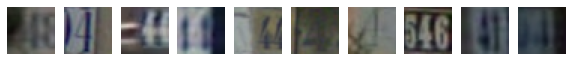

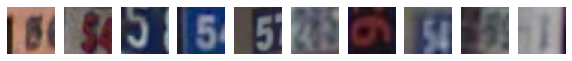

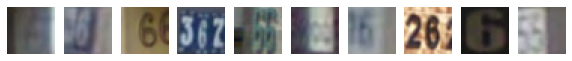

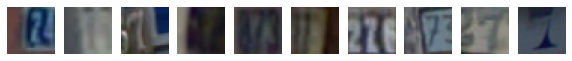

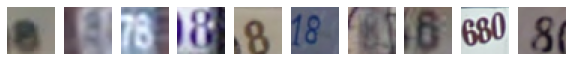

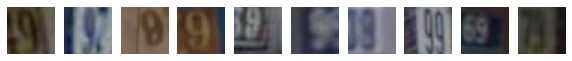

In [13]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    images_indxs = np.where((predictions == predicted_class) & (groud_truth == gt_class))
    visualize_images(val_indices[images_indxs], data)

visualize_predicted_actual(1, 1, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 2, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 3, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 4, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 5, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 6, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 9, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [14]:
# Experiment here!

In [22]:
model_1 = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100), 
             nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
            nn.BatchNorm1d(10)
         )
model_1.type(torch.FloatTensor)
optimizer = optim.SGD(model_1.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= True)
loss_history, train_history, val_history = train_model(model_1, train_loader, val_loader, loss, optimizer, 40, scheduler)

Average loss: 1.796258, Train accuracy: 0.414719, Val accuracy: 0.614429
Average loss: 1.347635, Train accuracy: 0.642818, Val accuracy: 0.690192
Average loss: 1.247060, Train accuracy: 0.690748, Val accuracy: 0.716743
Average loss: 1.195035, Train accuracy: 0.718186, Val accuracy: 0.731691
Average loss: 1.162588, Train accuracy: 0.732331, Val accuracy: 0.748345
Average loss: 1.135469, Train accuracy: 0.744480, Val accuracy: 0.747184
Average loss: 1.113566, Train accuracy: 0.751988, Val accuracy: 0.741519
Average loss: 1.095177, Train accuracy: 0.758540, Val accuracy: 0.766774
Average loss: 1.076451, Train accuracy: 0.768539, Val accuracy: 0.776398
Average loss: 1.062162, Train accuracy: 0.773624, Val accuracy: 0.774623
Average loss: 1.048170, Train accuracy: 0.777207, Val accuracy: 0.789025
Average loss: 1.039415, Train accuracy: 0.781285, Val accuracy: 0.780152
Average loss: 1.021459, Train accuracy: 0.787547, Val accuracy: 0.781858
Average loss: 1.010104, Train accuracy: 0.791182, V

In [23]:
model_2 = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
            nn.BatchNorm1d(10))
model_2.type(torch.FloatTensor)
optimizer = optim.Adam(model_2.parameters(), lr=1e-3, weight_decay=1e-4)
sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= True)

loss_history_2, train_history_2, val_history_2 = train_model(model_2, train_loader, val_loader, loss, optimizer, 40, sheduler)

Average loss: 1.378948, Train accuracy: 0.566580, Val accuracy: 0.700020
Average loss: 0.923940, Train accuracy: 0.720353, Val accuracy: 0.752781
Average loss: 0.802876, Train accuracy: 0.755827, Val accuracy: 0.790731
Average loss: 0.725900, Train accuracy: 0.780125, Val accuracy: 0.795577
Average loss: 0.685657, Train accuracy: 0.788418, Val accuracy: 0.792847
Average loss: 0.655248, Train accuracy: 0.797188, Val accuracy: 0.805679
Average loss: 0.631569, Train accuracy: 0.805361, Val accuracy: 0.804518
Average loss: 0.606590, Train accuracy: 0.812238, Val accuracy: 0.796601
Average loss: 0.587423, Train accuracy: 0.820343, Val accuracy: 0.821514
Average loss: 0.579234, Train accuracy: 0.820616, Val accuracy: 0.815780
Average loss: 0.564874, Train accuracy: 0.825479, Val accuracy: 0.813733
Average loss: 0.550837, Train accuracy: 0.827833, Val accuracy: 0.820900
Average loss: 0.545878, Train accuracy: 0.830410, Val accuracy: 0.827725
Average loss: 0.529961, Train accuracy: 0.836467, V

In [24]:
model_3 = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
            nn.BatchNorm1d(10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
            nn.BatchNorm1d(10))
model_3.type(torch.FloatTensor)
optimizer = optim.Adam(model_3.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= True)
loss_history_3, train_history_3, val_history_3 = train_model(model_3, train_loader, val_loader, loss, optimizer, 40, scheduler)

Average loss: 1.590751, Train accuracy: 0.470805, Val accuracy: 0.634564
Average loss: 1.123538, Train accuracy: 0.648261, Val accuracy: 0.684527
Average loss: 1.002301, Train accuracy: 0.689673, Val accuracy: 0.705276
Average loss: 0.925245, Train accuracy: 0.714893, Val accuracy: 0.707938
Average loss: 0.872431, Train accuracy: 0.731529, Val accuracy: 0.753191
Average loss: 0.827384, Train accuracy: 0.744207, Val accuracy: 0.758651
Average loss: 0.799027, Train accuracy: 0.754172, Val accuracy: 0.767251
Average loss: 0.773132, Train accuracy: 0.760690, Val accuracy: 0.772848
Average loss: 0.751061, Train accuracy: 0.770484, Val accuracy: 0.784179
Average loss: 0.728736, Train accuracy: 0.775057, Val accuracy: 0.777353
Average loss: 0.716839, Train accuracy: 0.779135, Val accuracy: 0.767866
Average loss: 0.700325, Train accuracy: 0.782770, Val accuracy: 0.774282
Average loss: 0.695029, Train accuracy: 0.784954, Val accuracy: 0.787318
Average loss: 0.676681, Train accuracy: 0.791694, V

In [21]:
model_4 = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
            nn.BatchNorm1d(10))
model_4.type(torch.FloatTensor)
optimizer = optim.Adam(model_4.parameters(), lr=1e-3, weight_decay=1e-4)
sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 3 , verbose= True)

loss_history_4, train_history_4, val_history_4 = train_model(model_4, train_loader, val_loader, loss, optimizer, 40)

Average loss: 1.407299, Train accuracy: 0.556991, Val accuracy: 0.693605
Average loss: 1.018465, Train accuracy: 0.688906, Val accuracy: 0.714559
Average loss: 0.896470, Train accuracy: 0.725540, Val accuracy: 0.755034
Average loss: 0.818529, Train accuracy: 0.746954, Val accuracy: 0.766228
Average loss: 0.766523, Train accuracy: 0.763113, Val accuracy: 0.786294
Average loss: 0.729278, Train accuracy: 0.773658, Val accuracy: 0.802403
Average loss: 0.698160, Train accuracy: 0.784118, Val accuracy: 0.790594
Average loss: 0.677713, Train accuracy: 0.788605, Val accuracy: 0.815303
Average loss: 0.660884, Train accuracy: 0.794287, Val accuracy: 0.804245
Average loss: 0.635832, Train accuracy: 0.801061, Val accuracy: 0.808341
Average loss: 0.633193, Train accuracy: 0.803791, Val accuracy: 0.810115
Average loss: 0.618221, Train accuracy: 0.807614, Val accuracy: 0.809979
Average loss: 0.605376, Train accuracy: 0.812920, Val accuracy: 0.815098
Average loss: 0.596689, Train accuracy: 0.812954, V

In [25]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy_1 = compute_accuracy(model_1, test_loader)
test_accuracy_2 = compute_accuracy(model_2, test_loader)
test_accuracy_3 = compute_accuracy(model_3, test_loader)
test_accuracy_4 = compute_accuracy(model_4, test_loader)
print("Test accuracy for model_1: %2.4f" % test_accuracy_1)
print("Test accuracy for model_2: %2.4f" % test_accuracy_2)
print("Test accuracy for model_3: %2.4f" % test_accuracy_3)
print("Test accuracy for model_4: %2.4f" % test_accuracy_4)

Test accuracy for model_1: 0.7255
Test accuracy for model_2: 0.7968
Test accuracy for model_3: 0.7845
Test accuracy for model_4: 0.8014
